# VADER analysis on scraped Twitter data and vector analysis of prevalent words in the corpus.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chartify
import seaborn as sns

import string
import re
from collections import Counter
from nltk.corpus import stopwords
import base64

stopwords = stopwords.words('english')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.base import TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import spacy
from spacy.lang.en import English
parser = English()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#import MND, KNN, RF, RNN/Keras

%matplotlib inline

C:\Users\Rober\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## reading in scraped cpg twitter data (partially cleaned)

In [2]:
df = pd.read_csv('./datasets/twitter/timeseries/time_master2.csv').drop(columns='Unnamed: 0')
df

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour
0,@SeventhGen,2018-01-01 03:34:56-05:00,"Hey Everyone Get samples, test products and ma...",0,Shantele_Marie,2018,1,Monday,2018-01,3
1,@SeventhGen,2018-01-01 04:38:23-05:00,"They've got fun products. Get samples, test pr...",0,Shantele_Marie,2018,1,Monday,2018-01,4
2,@DrBronner,2018-01-01 11:00:05-05:00,Grateful for every person who believes in the ...,8,DrBronner,2018,1,Monday,2018-01,11
3,@DrBronner,2018-01-01 11:00:06-05:00,We have more work to do in 2018 to stand up fo...,4,DrBronner,2018,1,Monday,2018-01,11
4,@DrBronner,2018-01-01 11:00:06-05:00,"This year, we donated approximately $7 million...",3,DrBronner,2018,1,Monday,2018-01,11
...,...,...,...,...,...,...,...,...,...,...
105410,@SeventhGen,2020-02-29 21:19:12-05:00,Did you know germs LOVE to hang out in coffee ...,0,Sophiacastilla2,2020,2,Saturday,2020-02,21
105411,@SeventhGen,2020-02-29 21:36:05-05:00,As a #generationgood member I got to try the n...,0,mamachristine17,2020,2,Saturday,2020-02,21
105412,@SeventhGen,2020-02-29 22:05:44-05:00,As a #generationgood member I got to try the n...,0,lbgoforth1978,2020,2,Saturday,2020-02,22
105413,@SeventhGen,2020-02-29 23:06:25-05:00,I was selected for a new baby kit of @seventhg...,0,CHEROKEEWOLFDOG,2020,2,Saturday,2020-02,23


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105415 entries, 0 to 105414
Data columns (total 10 columns):
artifact      105415 non-null object
datetime      105415 non-null object
text          105415 non-null object
retweets      105415 non-null int64
username      105415 non-null object
year          105415 non-null int64
month         105415 non-null int64
day           105415 non-null object
month_year    105415 non-null object
hour          105415 non-null int64
dtypes: int64(4), object(6)
memory usage: 8.0+ MB


# Conducting a Vader Sentiment Analysis Baseline before Cvec and TFIDF

In [4]:
analyser = SentimentIntensityAnalyzer()

In [5]:
sentiment = df['text'].apply(lambda x: analyser.polarity_scores(x))
df = pd.concat([df, sentiment.apply(pd.Series)], 1)

In [6]:
df.tail(2)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
105413,@SeventhGen,2020-02-29 23:06:25-05:00,I was selected for a new baby kit of @seventhg...,0,CHEROKEEWOLFDOG,2020,2,Saturday,2020-02,23,0.0,0.789,0.211,0.7096
105414,@SeventhGen,2020-02-29 23:11:57-05:00,As a #generationgood member I got to try the n...,0,lbgoforth1978,2020,2,Saturday,2020-02,23,0.0,0.786,0.214,0.8398


In [7]:
df.describe()

,retweets,year,month,hour,neg,neu,pos,compound
count,105415.000000,105415.000000,105415.000000,105415.000000,105415.000000,105415.000000,105415.000000,105415.000000
mean,0.615766,2018.664697,5.941621,13.560414,0.039291,0.723637,0.213708,0.426282
std,15.083483,0.617618,3.462276,5.879080,0.101624,0.210123,0.180284,0.457441
min,0.000000,2018.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.985500
25%,0.000000,2018.000000,3.000000,10.000000,0.000000,0.612000,0.000000,0.000000
50%,0.000000,2019.000000,6.000000,14.000000,0.000000,0.746000,0.204000,0.570700
75%,0.000000,2019.000000,9.000000,18.000000,0.000000,0.858000,0.324000,0.830600
max,3217.000000,2020.000000,12.000000,23.000000,1.000000,1.000000,1.000000,0.993100


## Importing 'plasticfree' data

In [8]:
plastic = pd.read_csv('./datasets/twitter/timeseries/timeseries_plasticfree_2018_2020.csv')

In [9]:
sentiment = plastic['text'].apply(lambda x: analyser.polarity_scores(x))
plastic = pd.concat([plastic, sentiment.apply(pd.Series)], 1)

In [10]:
plastic.tail(3)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
270131,plasticfree,2020-02-28 16:31:17-05:00,Sé parte de la iniciativa para generar un camb...,4,KiriPlanet,2020,2,Friday,2020-02,16,0.0,1.0,0.0,0.0
270132,plasticfree,2020-02-28 16:34:32-05:00,¡Empaque totalmente amigable con el medio ambi...,4,KiriPlanet,2020,2,Friday,2020-02,16,0.0,1.0,0.0,0.0
270133,plasticfree,2020-02-28 16:51:27-05:00,Be a planet saver with Tavos! #ecofriendly #pa...,0,TavosCanada,2020,2,Friday,2020-02,16,0.0,1.0,0.0,0.0


In [11]:
plastic.groupby(['artifact'])['compound'].mean()

artifact
plasticfree    0.220782
Name: compound, dtype: float64

## Vader Sentiment Scores

### There 91866 out of 105414 non-negative tweets according to vader on the brands 87%
#### 74K Positive ~74%
#### 13% Neutral
#### 13% Negative

### Average Vader Sentiment Score by brand: Anything above 5% is considered positive (-1 to 1 Scale)
#### SeventhGen == 46.8%
#### MrsMeyerClean == 41.6%
#### DrBronner == 29.8%
#### plasticfree == 22.1%

In [12]:
df['compound']

0         0.2960
1         0.6705
2         0.9594
3         0.0000
4         0.3182
           ...  
105410    0.8866
105411    0.8398
105412    0.8398
105413    0.7096
105414    0.8398
Name: compound, Length: 105415, dtype: float64

In [13]:
df.groupby(['artifact'])['compound'].mean()

artifact
@DrBronner         0.297818
@MrsMeyersClean    0.415865
@SeventhGen        0.467874
Name: compound, dtype: float64

In [14]:
df[df['compound'] > 0.05].head(3)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
0,@SeventhGen,2018-01-01 03:34:56-05:00,"Hey Everyone Get samples, test products and ma...",0,Shantele_Marie,2018,1,Monday,2018-01,3,0.0,0.855,0.145,0.2960
1,@SeventhGen,2018-01-01 04:38:23-05:00,"They've got fun products. Get samples, test pr...",0,Shantele_Marie,2018,1,Monday,2018-01,4,0.0,0.718,0.282,0.6705
2,@DrBronner,2018-01-01 11:00:05-05:00,Grateful for every person who believes in the ...,8,DrBronner,2018,1,Monday,2018-01,11,0.0,0.665,0.335,0.9594


In [15]:
ch = chartify.Chart(blank_labels=True, y_axis_type='density')
ch.set_title("Sentiment Distribution")
ch.set_subtitle("VADER Compound Score")#: Negative Sentiment < -0.05 < Neutral < 0.05 < Positive Sentiment")
ch.style.color_palette.reset_palette_order()
ch.plot.histogram(
    data_frame=df,
    values_column='compound',
    color_column='artifact',
    method='density',
    bins=20
    )
ch.callout.line(.05, 'height')  # Callout vertical line
ch.callout.line(-.05, 'height')  # Callout vertical line
ch.callout.text("Negative Sentiment", -.7, 2)
ch.callout.text("Positive Sentiment", .4, 2)
#ch.axes.set_xaxis_tick_format("0.00%")
ch.set_legend_location('outside_bottom')
ch.show()

## Share of Sentiment across brands ---> proportional rel volume, need to examine normalized by percentage of positive to negative. The below percentages are based off volume counts

### Share of Positive Sentiment

In [16]:
df[df['compound'] > 0.05].artifact.value_counts(normalize=True)

@SeventhGen        0.773408
@DrBronner         0.180295
@MrsMeyersClean    0.046297
Name: artifact, dtype: float64

In [17]:
df[df['compound'] > 0.05].artifact.value_counts()

@SeventhGen        57516
@DrBronner         13408
@MrsMeyersClean     3443
Name: artifact, dtype: int64

### Share of Negative Sentiment

In [18]:
df[df['compound'] < -0.05].artifact.value_counts()

@SeventhGen        10816
@DrBronner          2330
@MrsMeyersClean      403
Name: artifact, dtype: int64

In [19]:
# df[df['compound'] < -0.05].artifact.value_counts() / 

In [20]:
df.head(1)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
0,@SeventhGen,2018-01-01 03:34:56-05:00,"Hey Everyone Get samples, test products and ma...",0,Shantele_Marie,2018,1,Monday,2018-01,3,0.0,0.855,0.145,0.296


In [21]:
df.groupby('artifact').agg(['count'])

,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
,count,count,count,count,count,count,count,count,count,count,count,count,count
artifact,,,,,,,,,,,,,
@DrBronner,24206,24206,24206,24206,24206,24206,24206,24206,24206,24206,24206,24206,24206
@MrsMeyersClean,5154,5154,5154,5154,5154,5154,5154,5154,5154,5154,5154,5154,5154
@SeventhGen,76055,76055,76055,76055,76055,76055,76055,76055,76055,76055,76055,76055,76055


# Tokenize and Vectorize the corpus

In [22]:
df.text

0         Hey Everyone Get samples, test products and ma...
1         They've got fun products. Get samples, test pr...
2         Grateful for every person who believes in the ...
3         We have more work to do in 2018 to stand up fo...
4         This year, we donated approximately $7 million...
                                ...                        
105410    Did you know germs LOVE to hang out in coffee ...
105411    As a #generationgood member I got to try the n...
105412    As a #generationgood member I got to try the n...
105413    I was selected for a new baby kit of @seventhg...
105414    As a #generationgood member I got to try the n...
Name: text, Length: 105415, dtype: object

In [23]:
docs = df.text

In [ ]:
# cvec = CountVectorizer(stop_words='english',
#                       ngram_range=(1,3))
# vector_count = cvec.fit_transform(docs)

## Spacy 

### Function to do the following:
1.  remove personal pronouns
2.  stopwords
3.  punctuation
4. (DID NOT DO A COMPLETE LEMMATIZE OR STEM)

In [18]:
#adpated from     https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/machine%20learning%20spaCy.ipynb

nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [19]:
df.head(1)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
0,@SeventhGen,2018-01-01 03:34:56-05:00,"Hey Everyone Get samples, test products and ma...",0,Shantele_Marie,2018,1,Monday,2018-01,3,0.0,0.855,0.145,0.296


In [53]:
df[df['artifact'] == '@DrBronner']['text']

2         Grateful for every person who believes in the ...
3         We have more work to do in 2018 to stand up fo...
4         This year, we donated approximately $7 million...
5                                                          
6         Love love looovee you guys (that's me hugging ...
                                ...                        
105311    Interesting thread - it is my belief that the ...
105319    There’s no going back after using @DrBronner f...
105327    Goat milk soap and handmade soap bars and @DrB...
105336                                        Rock & rule. 
105381    Carbon Neutral by 2050? "Companies such as @pa...
Name: text, Length: 24206, dtype: object

### List comprehension to clean and concat all 'text' from tweets

In [37]:
bronner_text = [text for text in df[df['artifact'] == '@DrBronner']['text']]
seventhgen_text = [text for text in df[df['artifact'] == '@SeventhGen']['text']]
meyers_text = [text for text in df[df['artifact'] == '@MrsMeyersClean']['text']]

bronner_clean = cleanup_text(bronner_text)
bronner_clean = ' '.join(bronner_clean).split()
seventhgen_clean = cleanup_text(seventhgen_text)
seventhgen_clean = ' '.join(seventhgen_clean).split()
meyers_clean = cleanup_text(meyers_text)
meyers_clean = ' '.join(meyers_clean).split()

bronner_counts = Counter(bronner_clean)
seventhgen_counts = Counter(seventhgen_clean)
meyers_counts = Counter(meyers_clean)

### Common Words in '@DrBronner' mentions via Twitter

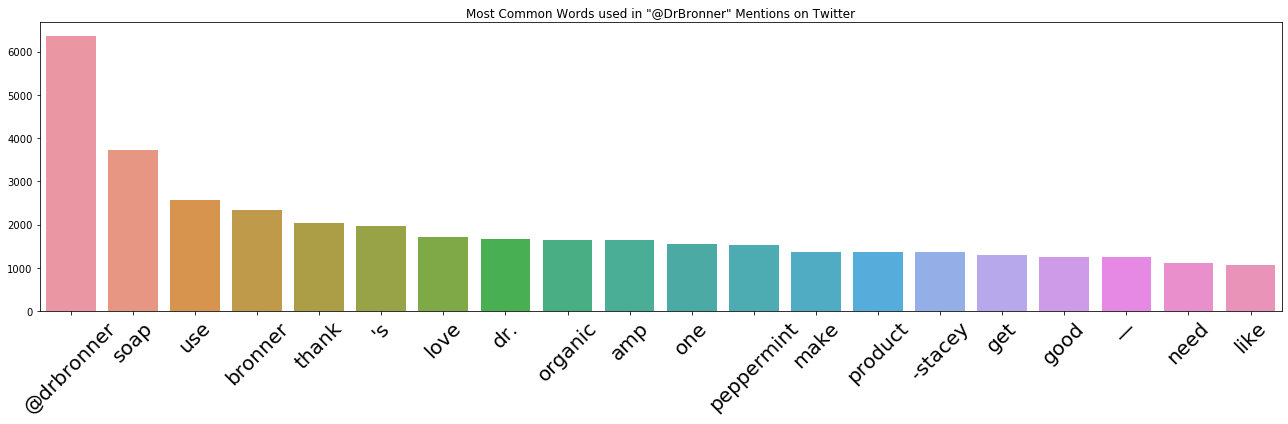

In [108]:
bronner_common_words = [word[0] for word in bronner_counts.most_common(20)]
bronner_common_counts = [word[1] for word in bronner_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=bronner_common_words, y=bronner_common_counts)
plt.title('Most Common Words used in "@DrBronner" Mentions on Twitter')
plt.xticks(rotation=45, fontsize=20)
plt.tight_layout()
plt.show()

In [97]:
bronner_counts_df = pd.DataFrame.from_dict(bronner_counts, orient='index').reset_index()
bronner_counts_df.columns = ['token', 'count']
bronner_counts_df

,token,count
0,grateful,65
1,every,268
2,person,81
3,believe,146
4,one,1559
...,...,...
25703,cpo,1
25704,pumping,1
25705,@lelanargi,1
25706,https://bit.ly/2t8ua8a,1


### Common Words in '@SeventhGen' mentions via Twitter

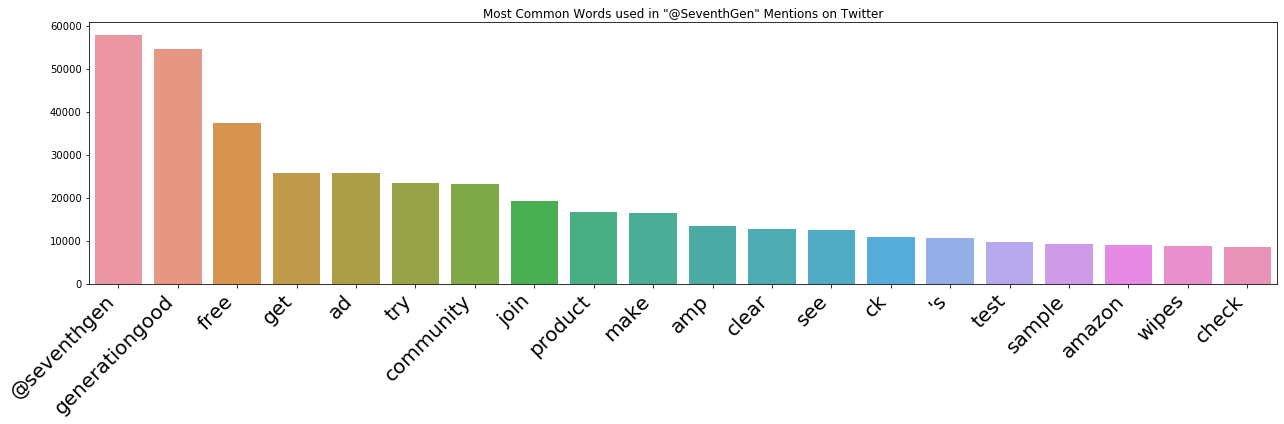

In [118]:
seventhgen_common_words = [word[0] for word in seventhgen_counts.most_common(20)]
seventhgen_common_counts = [word[1] for word in seventhgen_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=seventhgen_common_words, y=seventhgen_common_counts)
plt.title('Most Common Words used in "@SeventhGen" Mentions on Twitter')
plt.xticks(rotation=45, fontsize=20, ha='right')
plt.tight_layout()
plt.show()

### Common Words in '@MrsMeyersClean' mentions via Twitter

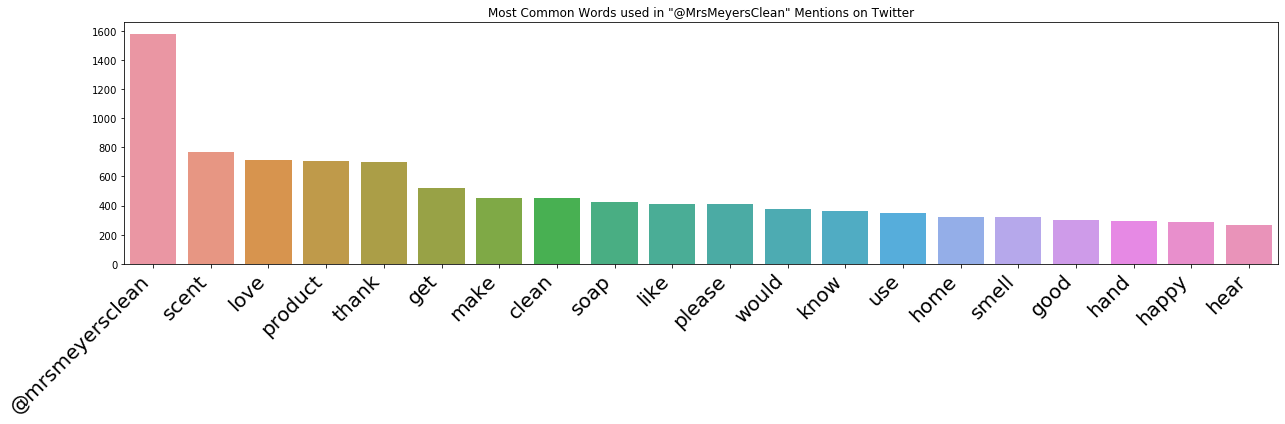

In [117]:
meyers_common_words = [word[0] for word in meyers_counts.most_common(20)]
meyers_common_counts = [word[1] for word in meyers_counts.most_common(20)]

fig = plt.figure(figsize=(18,6))
sns.barplot(x=meyers_common_words, y=meyers_common_counts)
plt.title('Most Common Words used in "@MrsMeyersClean" Mentions on Twitter')
plt.xticks(rotation=45, fontsize=20, ha='right')
plt.tight_layout()
plt.show()

### Adding in the 'plasticfree' tweets

#### List comprehension to clean and concat all 'text' from tweets

In [101]:
pf_text = [text for text in plastic[plastic['artifact'] == 'plasticfree']['text']]

pf_clean = cleanup_text(pf_text)
pf_clean = ' '.join(pf_clean).split()

pf_counts = Counter(pf_clean)

In [416]:
pf_counts;

#### Common Words in 'plasticfree' mentions via Twitter

In [102]:
pf_common_words = [word[0] for word in pf_counts.most_common(20)]
pf_common_counts = [word[1] for word in pf_counts.most_common(20)]

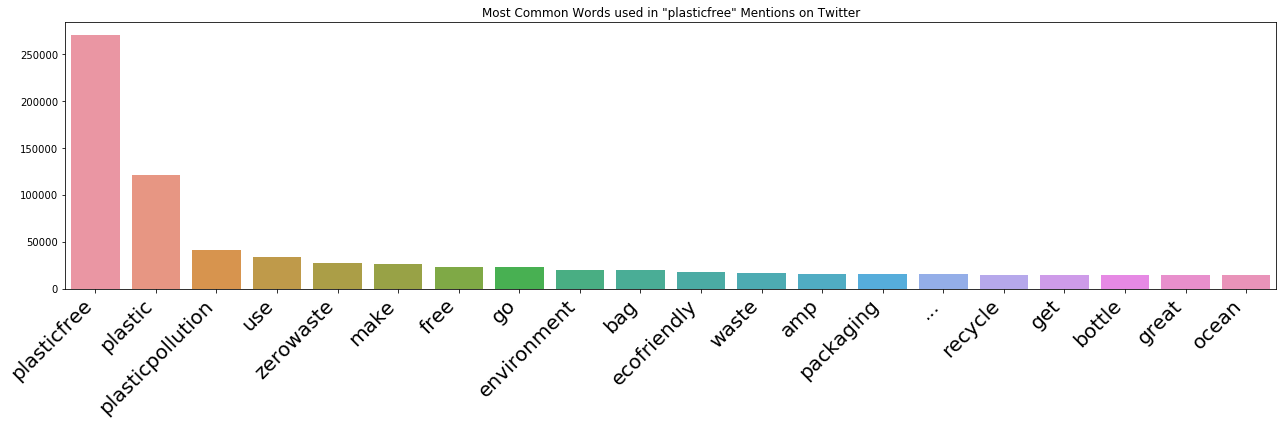

In [116]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=pf_common_words, y=pf_common_counts)
plt.title('Most Common Words used in "plasticfree" Mentions on Twitter')
plt.xticks(rotation=45, fontsize=20, ha='right')
plt.tight_layout()
plt.show()

In [104]:
pf_counts_df = pd.DataFrame.from_dict(pf_counts, orient='index').reset_index()
pf_counts_df.columns = ['token', 'count']
pf_counts_df

,token,count
0,small,3661
1,step,4408
2,create,2643
3,big,4409
4,change,8375
...,...,...
346341,toysofinstagram,1
346342,https://www.instagram.com/p/b9iaxp6glab/?igshi...,1
346343,nurdlehunters,1
346344,regresandoalorigen,2


 ## Find the common values between all the dataframes
 1. bronner, seventhgen, meyers, pf_common_words

In [380]:
common_df = (pd.DataFrame([pf_common_words, bronner_common_words, seventhgen_common_words, meyers_common_words]).T)
common_df.head(3)

,0,1,2,3
0,plasticfree,@drbronner,@seventhgen,@mrsmeyersclean
1,plastic,soap,generationgood,scent
2,plasticpollution,use,free,love


### Consolidated list of top 20 tokens from the 4 Twitter dfs (80 Input tokens)

In [ ]:
(pf_common_words + bronner_common_words + seventhgen_common_words + meyers_common_words)

In [219]:
from collections import Counter

In [300]:
#https://thispointer.com/python-find-duplicates-in-a-list-with-frequency-count-index-positions/
def getDuplicatesWithCount(listOfElems):
    ''' Get frequency count of duplicate elements in the given list '''
    dictOfElems = dict()
    # Iterate over each element in list
    for elem in listOfElems:
        # If element exists in dict then increment its value else add it in dict
        if elem in dictOfElems:
            dictOfElems[elem] += 1
        else:
            dictOfElems[elem] = 1    
     # Filter key-value pairs in dictionary. Keep pairs whose value is greater than 1 i.e. only duplicate elements from list.
    dictOfElems = { key:value for key, value in dictOfElems.items() if value > 1}
    # Returns a dict of duplicate elements and thier frequency count
    return dictOfElems

In [301]:
listOfElems = (pf_common_words + bronner_common_words + seventhgen_common_words + meyers_common_words + pf_common_words)
# Get a dictionary containing duplicate elements in list and their frequency count
dictOfElems = getDuplicatesWithCount(listOfElems)     
for key, value in dictOfElems.items():
        print(key , ' :: ', value)
        

use  ::  3
make  ::  4
free  ::  2
amp  ::  3
get  ::  4
soap  ::  2
thank  ::  2
's  ::  2
love  ::  2
product  ::  3
good  ::  2
like  ::  2


In [306]:
pd.Series(dictOfElems)

use        3
make       4
free       2
amp        3
get        4
soap       2
thank      2
's         2
love       2
product    3
good       2
like       2
dtype: int64

# Concat twitter dfs (brands and plasticfree)

In [313]:
df.head(1)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
0,@SeventhGen,2018-01-01 03:34:56-05:00,"Hey Everyone Get samples, test products and ma...",0,Shantele_Marie,2018,1,Monday,2018-01,3,0.0,0.855,0.145,0.296


In [314]:
plastic.head(1)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
0,plasticfree,2018-01-01 01:01:10-05:00,Small steps create big changes. #awareness #re...,8,JoyfullyECO,2018,1,Monday,2018-01,1,0.0,0.769,0.231,0.2732


In [343]:
df = df[df['artifact'] != 'plasticfree']

In [347]:
plastic['datetime'] = pd.to_datetime(plastic['datetime'])

In [350]:
plastic.sort_values('datetime', inplace=True)

In [357]:
df = pd.concat([df, plastic])

In [379]:
df.head(1)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
0,plasticfree,2018-01-01 01:01:10-05:00,Small steps create big changes. #awareness #re...,8,JoyfullyECO,2018,1,Monday,2018-01,1,0.0,0.769,0.231,0.2732


## Exporting to CSV as a checkpoint

In [360]:
# df.to_csv('./datasets/twitter/timeseries/twitter_3brands_plasticfree_vaderScores.csv')

In [24]:
df = pd.read_csv('./datasets/twitter/timeseries/twitter_3brands_plasticfree_vaderScores.csv').drop(columns='Unnamed: 0')

In [25]:
df = df.sort_values('datetime').reset_index().drop(columns='index')

In [26]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [27]:
df.tail(2)

,artifact,datetime,text,retweets,username,year,month,day,month_year,hour,neg,neu,pos,compound
375547,@SeventhGen,2020-02-29 23:06:25-05:00,I was selected for a new baby kit of @seventhg...,0,CHEROKEEWOLFDOG,2020,2,Saturday,2020-02,23,0.0,0.789,0.211,0.7096
375548,@SeventhGen,2020-02-29 23:11:57-05:00,As a #generationgood member I got to try the n...,0,lbgoforth1978,2020,2,Saturday,2020-02,23,0.0,0.786,0.214,0.8398


# Pickle / Dill For Saving: 
## All variables above are now tightly placed below

In [12]:
#adpated from     https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/machine%20learning%20spaCy.ipynb

docs = df.text
nlp = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [33]:
bronner_text = [text for text in df[df['artifact'] == '@DrBronner']['text']]
seventhgen_text = [text for text in df[df['artifact'] == '@SeventhGen']['text']]
meyers_text = [text for text in df[df['artifact'] == '@MrsMeyersClean']['text']]
print('1 good')
bronner_clean = cleanup_text(bronner_text)
bronner_clean = ' '.join(bronner_clean).split()
seventhgen_clean = cleanup_text(seventhgen_text)
seventhgen_clean = ' '.join(seventhgen_clean).split()
meyers_clean = cleanup_text(meyers_text)
meyers_clean = ' '.join(meyers_clean).split()
print('2 good')
bronner_counts = Counter(bronner_clean)
seventhgen_counts = Counter(seventhgen_clean)
meyers_counts = Counter(meyers_clean)
print('3 good')
pf_text = [text for text in df[df['artifact'] == 'plasticfree']['text']]
pf_clean = cleanup_text(pf_text)
pf_clean = ' '.join(pf_clean).split()
pf_counts = Counter(pf_clean)
print('4 good')
bronner_common_words = [word[0] for word in bronner_counts.most_common(20)]
bronner_common_counts = [word[1] for word in bronner_counts.most_common(20)]
seventhgen_common_words = [word[0] for word in seventhgen_counts.most_common(20)]
seventhgen_common_counts = [word[1] for word in seventhgen_counts.most_common(20)]
meyers_common_words = [word[0] for word in meyers_counts.most_common(20)]
meyers_common_counts = [word[1] for word in meyers_counts.most_common(20)]
pf_common_words = [word[0] for word in pf_counts.most_common(20)]
pf_common_counts = [word[1] for word in pf_counts.most_common(20)]

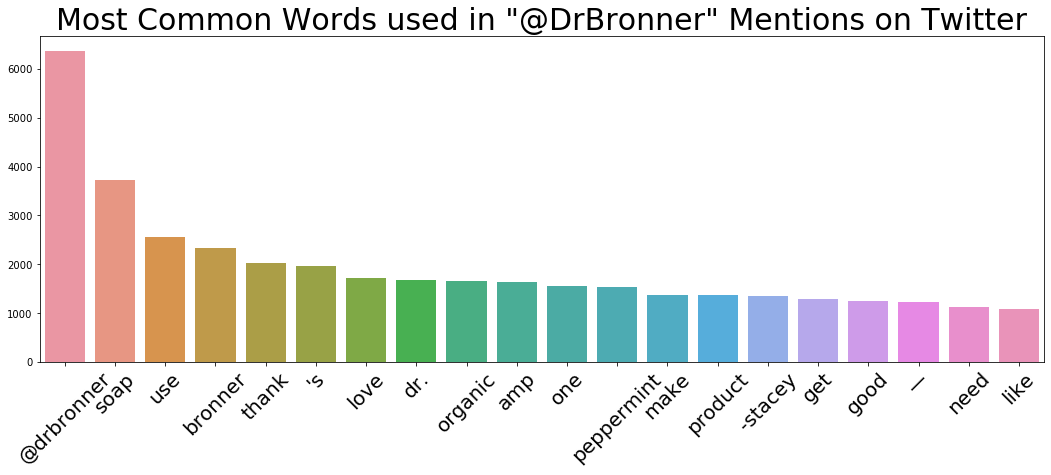

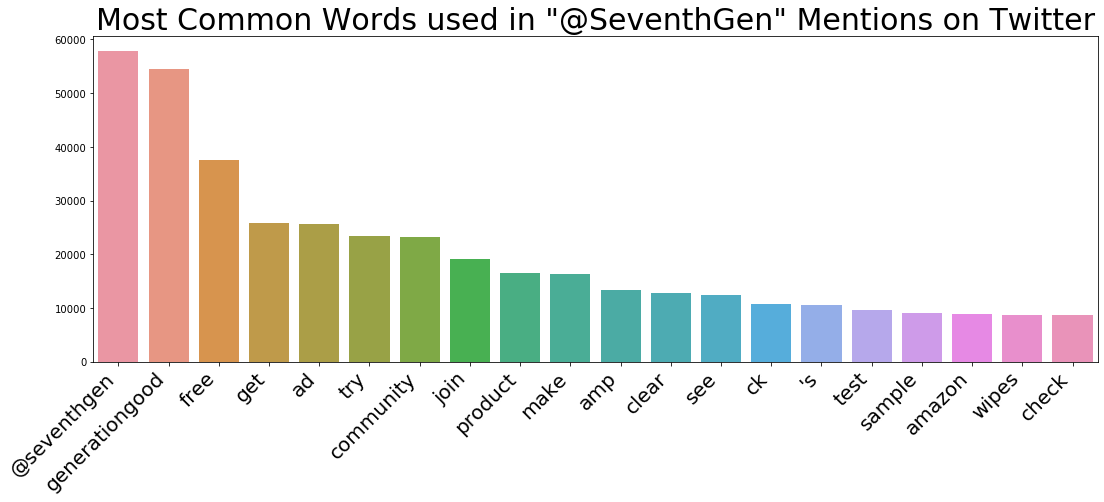

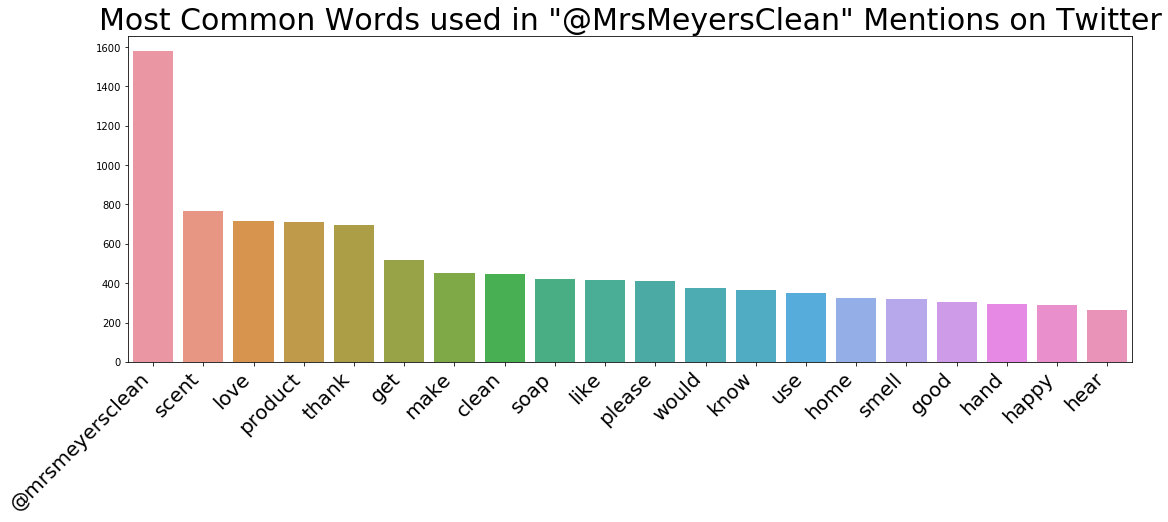

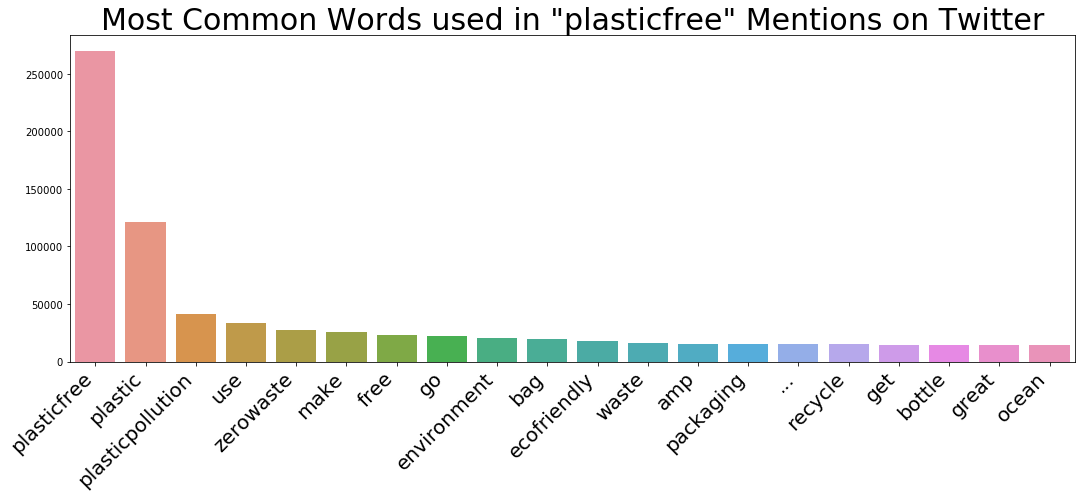

In [31]:
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, sharey=True)

fig = plt.figure(figsize=(18,6))
sns.barplot(x=bronner_common_words, y=bronner_common_counts)
plt.title('Most Common Words used in "@DrBronner" Mentions on Twitter', fontsize=30)
plt.xticks(rotation=45, fontsize=20)
# plt.tight_layout()
# plt.show()

fig = plt.figure(figsize=(18,6))
sns.barplot(x=seventhgen_common_words, y=seventhgen_common_counts)
plt.title('Most Common Words used in "@SeventhGen" Mentions on Twitter', fontsize=30)
plt.xticks(rotation=45, fontsize=20, ha='right')
# plt.tight_layout()
# plt.show()

fig = plt.figure(figsize=(18,6))
sns.barplot(x=meyers_common_words, y=meyers_common_counts)
plt.title('Most Common Words used in "@MrsMeyersClean" Mentions on Twitter', fontsize=30)
plt.xticks(rotation=45, fontsize=20, ha='right')
# plt.tight_layout()
# plt.show()

fig = plt.figure(figsize=(18,6))
sns.barplot(x=pf_common_words, y=pf_common_counts)
plt.title('Most Common Words used in "plasticfree" Mentions on Twitter', fontsize=30)
plt.xticks(rotation=45, fontsize=20, ha='right')
# plt.tight_layout()
# plt.show()

# plt.subplots_adjust(hspace=0.5)
# plt.subplots()
plt.show()

## This gets the common tokens across all categories

In [40]:
#https://thispointer.com/python-find-duplicates-in-a-list-with-frequency-count-index-positions/
def getDuplicatesWithCount(listOfElems):
    ''' Get frequency count of duplicate elements in the given list '''
    dictOfElems = dict()
    # Iterate over each element in list
    for elem in listOfElems:
        # If element exists in dict then increment its value else add it in dict
        if elem in dictOfElems:
            dictOfElems[elem] += 1
        else:
            dictOfElems[elem] = 1    
     # Filter key-value pairs in dictionary. Keep pairs whose value is greater than 1 i.e. only duplicate elements from list.
    dictOfElems = { key:value for key, value in dictOfElems.items() if value > 1}
    # Returns a dict of duplicate elements and thier frequency count
    return dictOfElems

listOfElems = (pf_common_words + bronner_common_words + seventhgen_common_words + meyers_common_words + pf_common_words)
# Get a dictionary containing duplicate elements in list and their frequency count
dictOfElems = getDuplicatesWithCount(listOfElems)     
# for key, value in dictOfElems.items():
#        print(key , ' :: ', value)
        
pd.Series(dictOfElems).sort_values(ascending=False)

make                5
get                 5
use                 4
amp                 4
product             3
free                3
like                2
waste               2
plastic             2
plasticpollution    2
zerowaste           2
go                  2
environment         2
bag                 2
ecofriendly         2
packaging           2
good                2
...                 2
recycle             2
bottle              2
great               2
ocean               2
soap                2
thank               2
's                  2
love                2
plasticfree         2
dtype: int64

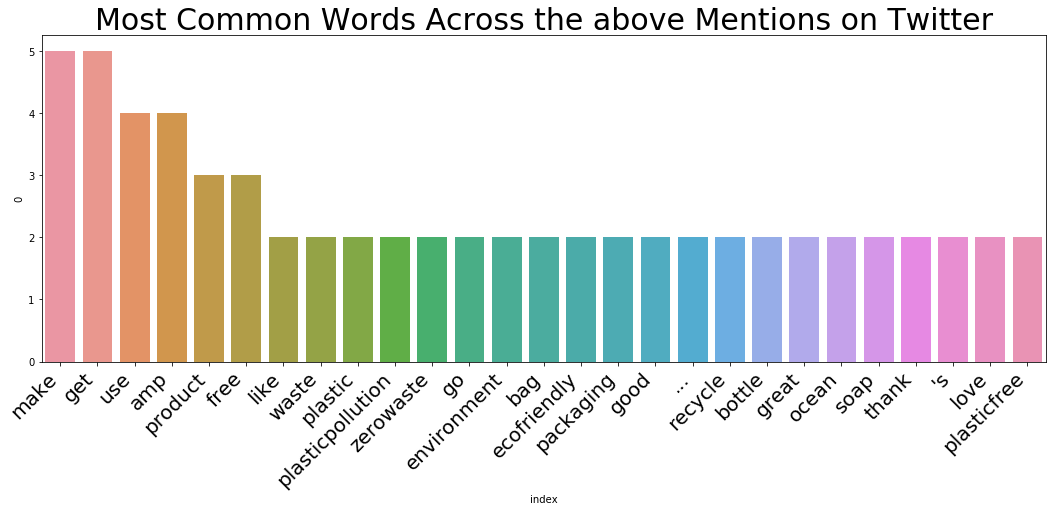

In [81]:
fig = plt.figure(figsize=(18,6))
sns.barplot(x=(pd.Series(dictOfElems).sort_values(ascending=False).reset_index()['index']), y=((pd.Series(dictOfElems).sort_values(ascending=False)).reset_index()[0]))
plt.title('Most Common Words Across the above Mentions on Twitter', fontsize=30)
plt.xticks(rotation=45, fontsize=20, ha='right')
# plt.tight_layout()
# plt.show()

# plt.subplots_adjust(hspace=0.5)
# plt.subplots()
plt.show()

In [32]:
import dill

In [82]:
dill.dump_session('./dill/18_token_vectorize_twitter_01.db')

In [ ]:
# dill.load_session('./dill/18_token_vectorize_twitter_01.db')